In [17]:
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

% matplotlib inline
sns.set()
sns.set_color_codes()

# Construct xarray for real gdp series 

### Normalize data sets to be constant to 2015

* Construct xarray with other sources (PWT rgdpna, UN, WB, WEO) 
  
* Construct GDP real index **<span style="color:white; background:limegreen;">DONE</span>**
    * UN: nominal series x gdp index **<span style="color:white; background:limegreen;">DONE</span>** (total x)
    * WB: nominal series x gdp index **<span style="color:white; background:maroon;">STARTED</span>**

    * IMF_WEO: calculate gdp index
    * PWT rgdpna: 
* Compare top 10 countries
* Compare mortality countries
* Compare ratio of MKT to PPP




| source     | base year |  
|---------|------|
| WB      | 2010 |  
| UN_NA   | 2005 |
| IMF_WEO | 2015?|
| PWT_rgdpna| 2011|

#### Table1: Base year used by different sources constant series

Status:
**<span style="color:lime; background:green;">In Progress</span>** 
**<span style="color:white; background:maroon;">STARTED</span>**
**<span style="color:white; background:limegreen;">DONE</span>**


### GDP index
$$GDPindex_{i_b} = \frac{gdp_{i_b}}{gdp_{i=b}}$$

where
    
    i = target year (any year in series)
    
    b = base year (2010 for WB, 2005 for UN_na, and 2015 for IMF weo)
    
    b (small one) = base year that the real gdp is calculated with respect to. ie. gdp values are in base year values.



Mike's Notes
```
current_gdp # dataframe with iso x year, giving time series of
            # current GDP (USD) using market exchange rates

real_gdp    # dataframe with iso x year, giving time series of
            # real GDP (USD) with a variety of base years

target_base_year = 2015 # desired real GDP series base year

# produce index of real growth relative to 2015
real_gdp_index = real_gdp.div(real_gdp[target_base_year], axis=0)

# produce time series of real GDP with 2015 basis
real_gdp_target_base = real_gdp_index.mul(
    current_gdp[target_base_year],
    axis=0)

# sum real GDP by country --> global real gdp
global_real_gdp_target_base = real_gdp_target_base.sum()
```

### Alohamora (data)
#### a) gdp - current series (to multiply by gdi to calculate real series)
#### b) gdp - real/constant series (to compute gdp index with respect to same year - 2015)

In [18]:
dir_path = os.environ['ZERG']

# file locations!

# un
un_current_file = dir_path + 'data/un/national_accounts/un_na_gdp_current_usd.xls'
un_constant_file = dir_path + 'data/un/national_accounts/un_na_gdp_constant_usd.xls'
#un_constant_file = dir_path+ 'data/un/munged/un_national_acct_real_gdp_2005.csv' # gdp only

#wb
wb_current_file = dir_path + 'data/wb/gdp/gdp_current/API_NY.GDP.MKTP.CD_DS2_en_csv_v2.csv'
wb_current_meta = dir_path + 'data/wb/gdp/gdp_current/Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2.csv'

wb_constant_file = dir_path + 'data/wb/gdp/gdp_constant/API_NY.GDP.MKTP.KD_DS2_en_csv_v2.csv'
wb_constant_meta = dir_path + 'data/wb/gdp/gdp_constant/Metadata_Country_API_NY.GDP.MKTP.KD_DS2_en_csv_v2.csv'

# pwt
pwt_all_file = dir_path + 'data/pwt/pwt90.xlsx'

# imf-weo
# imf files have to be excel. for some reason some numbers include commas RESOLVED
imf_weo_current = dir_path + 'data/imf/weo/weo_oct2017_gdp_current_usd_bil.csv'
imf_weo_constant = dir_path + 'data/imf/weo/weo_oct2017_gdp_constant_dcu_bil.csv'

# other meta data
rhg_regions = dir_path + 'data/meta_data/iso_map_based_on_rhg_regions.xls'

In [19]:
# UN
df_un_current = pd.read_excel(un_current_file, skiprows=2)
df_un_constant = pd.read_excel(un_constant_file, skiprows=2)

# WB
df_wb_current = pd.read_csv(wb_current_file, skiprows=4) # updated 12/22/2017
df_wb_current_meta = pd.read_csv(wb_current_meta)

df_wb_constant = pd.read_csv(wb_constant_file, skiprows=4) # updated 12/22/2017 too?
df_wb_constant_meta = pd.read_csv(wb_constant_meta)

# PWT
df_pwt = pd.read_excel(pwt_all_file, sheetname='Data')

In [20]:
# IMF - WEO
df_weo_current = pd.read_csv(imf_weo_current, na_values=['n/a'], keep_default_na=True)
df_weo_constant = pd.read_csv(imf_weo_constant, na_values=['n/a'], keep_default_na=True)

### Z- Convenience functions 
#### a) iso mapper

In [21]:
iso = pd.read_excel(rhg_regions, sheetname='mapper_iso_to_country_name')

# rhg_regions file updated to include Syria and Kosovo
iso_map = iso[['countryName', 'iso']].set_index('countryName').to_dict()['iso']

In [22]:
iso_map_un_na = iso[['countryNameUNNA', 'iso']]
iso_map_un_na.columns.values[0] = 'countryName'
iso_map_un_na = iso_map_un_na.set_index('countryName').to_dict()['iso']

#### b) munging dataframe (column filtering. indexing, add column..)

In [53]:
def drop_non_years(_df):
    def _is_year(_y):
        try:
            float(_y)
            return True
        except ValueError:
            return False
    return _df[[x for x in _df.columns if _is_year(x)]] 

def set_col_as_index(_df, _col_name):
    return _df.set_index(_col_name)

# set year as columns name
def set_col_idx_name(_df, col_idx_name='year'):
    _df.columns.name = col_idx_name
    return _df

def add_iso_column(_df, _country_name_col, data_source='general'):
    # uses iso_map (global dict)
    map_to_iso = lambda c: iso_map[c] if iso_map.get(c) else c # c for country name
    map_to_iso_un = lambda c: iso_map_un_na[c] if iso_map_un_na.get(c) else c # c for country name

    if 'iso' in _df.columns:
        pass
    elif data_source is 'un':
        v_map = np.vectorize(map_to_iso_un)
        assigned = _df.assign(iso=v_map(_df[_country_name_col]))
    else:
        v_map = np.vectorize(map_to_iso)
        assigned = _df.assign(iso=v_map(_df[_country_name_col]))
    return assigned

In [62]:
def prep_dataframe(_df, _source, _country_col_name):
    """
    Prep data frame for further analysis by doing 4 steps below. Uses these functions:
        add_iso_column
        set_col_as_index
        drop_non_years
        set_col_idx_name
        get_un_na_gdp_only (local function)
        all other functions global for now.
    
    Parameters
    ----------
    _df: DataFrame
        country x year, with gdp values (contains multiple countries across years)

    _source: str
        string acronym for data source. one of ['un', 'wb', 'imf_weo', 'pwt']
        Used for iso mapping
        
    _country_col_name: str
        name of column containing country names. one of 
        ('CountryName', 'Country', 'countryName', etc.) 
        Used for iso mapping
        
    Returns
    -------
    indexed: DataFrame
        return dataframe with new iso column added if missing before, dropped 
        columns that are not years (ex. IndicatorGroup), set existing column
        values as type floasm 
    =======
    
    """
    
    #get only GDP indicator (UN only) - move this out
    get_un_na_gdp_only = lambda _df2: _df2[_df2['IndicatorName'].str.startswith('Gross Domestic Product')] 

    #TODO: make a map of source type to lambdas, bc different country requires different prepping
    # return here if source type is not supported
    
    # 0/ filter indicators
    # 1/ add iso column (both UN, WB)
    if _source == 'un':
        _filtered = get_un_na_gdp_only(_df)
        _iso_added = add_iso_column(_filtered, _country_col_name, _source)
    
    elif _source == 'wb':
        _iso_added = _df.assign(iso=_df['Country Code'])  # this is getting unclean. the function assume
        # knowledge of details of data column name, and assumes it to be static. good for now..

    elif _source == 'imf_weo':
        _iso_added = _df.copy()
        
    # 1/ set iso as index
    _iso_indexed = set_col_as_index(_iso_added, 'iso')
        
    # 2/ drop non_year columns
    _dropped = drop_non_years(_iso_indexed)
    _dropped.columns = _dropped.columns.astype(int)
    
    # 3/ set col value types as float
    _converted = _dropped.astype(float)
    
    # 4/ set year as column index name
    _indexed = set_col_idx_name(_converted)
    
    return _indexed


In [25]:
# WB specific - using metadata to filter aggregates

In [26]:
def wb_filter_non_countries(_df, _metadata):
    """
    Uses metadata and data to filter out rows that are not countries. 
    Country Code column that is in both dataframes are used to merge on. 
    IncomeGroup column which is null for aggregates (i.e. not countries) is
    used to filter non-countries. 
    
    Parameters
    ----------
     _df : pd.DataFrame
        either income or population data
        
    _metadata : pd.DataFrame
        metadata on a list of entries including countries and non-countries 
        data source is from the World Bank
        has IncomeGroup column that is not null for countries (217)
    
    Note: source - task3_WB_analysis
    
    Returns
    -------
    filtered: DataFrame
        returns values with only country data (217 rows)
        
    """
    _merged = _df.merge(_metadata, on='Country Code')
    aggregate_mask = _merged['IncomeGroup'].isnull()
    return _merged[~aggregate_mask]  

### plotting

In [27]:
# lets simplify
def label_axes(_ax, _x_label, _y_label, _title):
    _ax.set_xlabel(_x_label, fontsize=14)
    _ax.set_ylabel(_y_label, fontsize=14)
    _ax.set_title(_title, fontsize=14)

In [28]:
# calculate GDP index
def calculate_real_gdp_index(_df, _source):
    """
        Converts real constant gdp series to real gdp index. 
        For each country (row), gdp time series is divided by the gdp value from the given base year,
        resulting in gdp index series. Pandas apply method with axis=columns is used.
        
        Parameters
        ----------
        _df : DataFrame
            dataframe containing real constant gdp values. Rows are countries and columns and years.
            two indices are year (df.column.name) and iso (for primary index)
        _source : str
            string acronym for given data source. one of ['un', 'wb', 'imf_weo']
        Keeps nan values for any missing value.
        
        Returns
        -------
        df_gdi: DataFrame
            contains real gdp series indices
    """
    # base year of a given data source
    # base year in this context means vaue that real GDP series is constant with respect to. 
    get_gdp_base_year = {
        'un': 2005, 
        'wb': 2010,
        'imf_weo': 2015
    }
    base_year = get_gdp_base_year[_source]
    df_gdi = _df.div(_df[base_year], axis=0)
    return df_gdi

In [29]:
def normalize_real_gdi(list_of_df, norm_year=2015):
    '''
        Normalizes real gdp index series from different data sources, so gdp index is
        1 relative to same year, and thus, comparable.
        
        Parameters
        ----------
        list_of_df: list
            list containing dataframes of real GDP index series
        norm_year: int, defaults to 2015 
            year to which gdp index series should be normalized (i.e. GDP index should
            be 1 for that year, and other values adjusted accordingly)
            
            Notes:
            
            Calling this parameter norm_year (normalization year) to distinguish 
            from any random year, but this is not an official term.
    '''
    def normalize_real_gdi_per_source(_df, norm_year):
        return _df.div(_df[norm_year], axis=0)
    
    return [normalize_real_gdi_per_source(_df, norm_year) for _df in list_of_df]    

## I. Prep DATA

1) individual per source

2) use `prep_dataframe` for all relevant sources 

Next: Calculate GDI

### First: UN
#### a) UN nominal series

In [30]:
un_current_prepped = prep_dataframe(df_un_current, 'un', 'Country')

In [31]:
assert un_current_prepped.shape[0] == 220

In [32]:
un_current_prepped.loc[['KOR', 'USA', 'CHN', 'BRA', 'IND']] # manual confirmation with downloaded, unmodified doc

year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
iso,,,,,,,,,,,,,,,,,,,,,
KOR,8.999348e+09,9.890032e+09,1.084211e+10,1.384183e+10,1.948192e+10,2.170475e+10,2.977934e+10,3.826508e+10,5.170062e+10,6.656798e+10,...,1.122679e+12,1.002219e+12,9.019350e+11,1.094499e+12,1.202464e+12,1.222807e+12,1.305605e+12,1.411334e+12,1.382764e+12,1.411246e+12
USA,1.075900e+12,1.167800e+12,1.282400e+12,1.428500e+12,1.548800e+12,1.688900e+12,1.877600e+12,2.086000e+12,2.356600e+12,2.632100e+12,...,1.447764e+13,1.471858e+13,1.441874e+13,1.496437e+13,1.551793e+13,1.615525e+13,1.669152e+13,1.742761e+13,1.812071e+13,1.862448e+13
CHN,8.964951e+10,9.718461e+10,1.092974e+11,1.341901e+11,1.396441e+11,1.586407e+11,1.528948e+11,1.704144e+11,2.158529e+11,2.622637e+11,...,3.571451e+12,4.604285e+12,5.121680e+12,6.066351e+12,7.522103e+12,8.570348e+12,9.635026e+12,1.053453e+13,1.122619e+13,1.121828e+13
BRA,3.521386e+10,3.933187e+10,5.062384e+10,7.167268e+10,9.188796e+10,1.080514e+11,1.277414e+11,1.486717e+11,1.688034e+11,1.860953e+11,...,1.397114e+12,1.695855e+12,1.666996e+12,2.208838e+12,2.616157e+12,2.465228e+12,2.472819e+12,2.456044e+12,1.803650e+12,1.795926e+12
IND,5.960291e+10,6.394412e+10,6.955567e+10,8.294735e+10,9.361918e+10,9.738617e+10,9.812194e+10,1.138546e+11,1.317069e+11,1.457506e+11,...,1.169473e+12,1.254803e+12,1.297597e+12,1.650635e+12,1.871918e+12,1.860877e+12,1.917054e+12,2.039198e+12,2.132755e+12,2.259642e+12


#### b) UN real series (GDI)

In [33]:
moo = pd.DataFrame({'a': pd.Series([1.0,100.0,1.0]), 'b': pd.Series([0.5,1.0,0.5])})

In [34]:
cow = pd.DataFrame({'a': pd.Series([1.0,2.0,3.0]), 'b': pd.Series([4.0,5.5,10.0])})

In [35]:
moo.multiply(cow)

,a,b
0,1.0,2.0
1,200.0,5.5
2,3.0,5.0


In [36]:
# reuse
get_un_na_gdp_only = lambda _df2: _df2[_df2['IndicatorName'].str.startswith('Gross Domestic Product')] 

un_constant = get_un_na_gdp_only(df_un_constant)

### Second: world bank

In [37]:
wb_current_filtered = wb_filter_non_countries(df_wb_current, df_wb_current_meta)
wb_constant_filtered = wb_filter_non_countries(df_wb_constant, df_wb_constant_meta)

In [38]:
assert (wb_current_filtered.shape == wb_constant_filtered.shape == (217,68))

In [39]:
# wb_current_filtered.columns

In [40]:
wb_current_filtered[201:204]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,Unnamed: 62,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
245,Ukraine,UKR,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.335034e+11,9.103096e+10,9.327048e+10,NaN,NaN,Europe & Central Asia,Lower middle income,The new base year is 2010.,Ukraine,NaN
247,Uruguay,URY,GDP (current US$),NY.GDP.MKTP.CD,1.242289e+09,1.547389e+09,1.710004e+09,1.539682e+09,1.975702e+09,1.890769e+09,...,5.723601e+10,5.327430e+10,5.241972e+10,NaN,NaN,Latin America & Caribbean,High income,NaN,Uruguay,NaN
248,United States,USA,GDP (current US$),NY.GDP.MKTP.CD,5.433000e+11,5.633000e+11,6.051000e+11,6.386000e+11,6.858000e+11,7.437000e+11,...,1.739310e+13,1.812071e+13,1.862448e+13,NaN,NaN,North America,High income,Fiscal year end: September 30; reporting perio...,United States,NaN


### Ender: IMF - WEO

In [58]:
# df_weo_current

In [50]:
# prep weo current
# weo specific munging

df_weo_current.columns
weo_current_assigned = df_weo_current.assign(iso=df_weo_current['ISO']) 
country_estimates_start_after = weo_current_assigned['Estimates Start After'] # may be useful later

# print(country_estimates_start_after.value_counts()) # set 2016 as last year (Good for now)
# filter out 2017 after prepping (only years left) should be 1980 -2016 then
# drop 2017 and after (projections) FOR NOW..?

In [51]:
# prep weo constant

df_weo_constant.columns
weo_constant_assigned = df_weo_constant.assign(iso=df_weo_constant['ISO']) 
country_estimates_start_after2 = weo_constant_assigned['Estimates Start After']

# print(country_estimates_start_after2.value_counts()) # set 2016 as last year (Good for now)

### Fourth: PWT

### Siblings: Prep dataframe (constant)

In [65]:
wb_constant_prepped = prep_dataframe(wb_constant_filtered, 'wb', 'Country Name')

In [66]:
un_constant_prepped = prep_dataframe(un_constant, 'un', 'Country')
wb_constant_prepped = prep_dataframe(wb_constant_filtered, 'wb', 'Country Name').loc[:,1960:2016]
wb_current_prepped = prep_dataframe(wb_current_filtered, 'wb', 'Country Name').loc[:,1960:2016]

In [67]:
# WB:drop 2017 from both current and constant (all null)

In [68]:
assert (wb_constant_prepped.shape == wb_current_prepped.shape == (217,57))

In [69]:
weo_current_prepped = prep_dataframe(weo_current_replaced, 'imf_weo', 'iso').loc[:, 1980:2016]

In [70]:
# drop 2017 on from WEO usually 2017 and on are projections
# projection start date varies by country - deal with this later (red flag)

weo_current_prepped = prep_dataframe(weo_current_replaced, 'imf_weo', 'iso').loc[:, 1980:2016]
weo_constant_prepped = prep_dataframe(weo_constant_replaced, 'imf_weo', 'iso').loc[:, 1980:2016]

In [71]:
assert(weo_current_prepped.shape == weo_constant_prepped.shape)

In [75]:
# # some sanity checks (select countries such as Korea were disappearing earlier due to prep_dataframe. Resolved now)

# wb_current_filtered[wb_current_filtered['Country Code']=='KOR']
# wb_constant_filtered[wb_current_filtered['Country Code']=='KOR']

In [76]:
wb_current_prepped.loc[['USA', 'KOR', 'BRA']]

year,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
iso,,,,,,,,,,,,,,,,,,,,,
USA,5.433000e+11,5.633000e+11,6.051000e+11,6.386000e+11,6.858000e+11,7.437000e+11,8.150000e+11,8.617000e+11,9.425000e+11,1.019900e+12,...,1.447764e+13,1.471858e+13,1.441874e+13,1.496437e+13,1.551793e+13,1.615526e+13,1.669152e+13,1.739310e+13,1.812071e+13,1.862448e+13
KOR,3.957874e+09,2.417238e+09,2.813934e+09,3.988246e+09,3.458518e+09,3.120308e+09,3.928171e+09,4.854576e+09,6.117260e+09,7.675805e+09,...,1.122679e+12,1.002219e+12,9.019350e+11,1.094499e+12,1.202464e+12,1.222807e+12,1.305605e+12,1.411334e+12,1.382764e+12,1.411246e+12
BRA,1.516557e+10,1.523685e+10,1.992629e+10,2.302148e+10,2.121189e+10,2.179004e+10,2.706272e+10,3.059183e+10,3.387588e+10,3.745890e+10,...,1.397084e+12,1.695825e+12,1.667020e+12,2.208872e+12,2.616202e+12,2.465189e+12,2.472807e+12,2.455993e+12,1.803653e+12,1.796187e+12


## II. Calculate real gdp_index  (Adv prepping? \o/)

    * UN (x)
    
    * WB (x)
        
    * IMF-WEO ( )
    
    * PWT ( )

In [77]:
# weo_gdi = calculate_real_gdp_index(weo_constant_prepped, 'imf_weo')

In [78]:
un_gdi = calculate_real_gdp_index(un_constant_prepped, 'un')
wb_gdi = calculate_real_gdp_index(wb_constant_prepped, 'wb')
weo_gdi = calculate_real_gdp_index(weo_constant_prepped, 'imf_weo')

In [79]:
[un_gdi_norm, wb_gdi_norm, weo_gdi_norm] = normalize_real_gdi([un_gdi, wb_gdi, weo_gdi])

In [80]:
# un calculate real series using gdi and nominal series!!@#!@#!@#!@3

In [81]:
un_real_b2015 = un_gdi_norm.multiply(un_current_prepped)

In [82]:
wb_real_b2015 = wb_gdi_norm.multiply(wb_current_prepped) # wb

In [93]:
weo_real_b2015 = weo_gdi_norm.multiply(weo_current_prepped)
weo_real_b2015 = weo_real_b2015*10**9 # convert billions of USD to absolute

print((weo_real_b2015.columns == [range(1980, 2017)]).all())

True


### warning: dropping 2016 since it's all nan


In [84]:
un_real_b2015 = un_real_b2015.loc[:,1970:2015] # should move this to prepping with wb prep

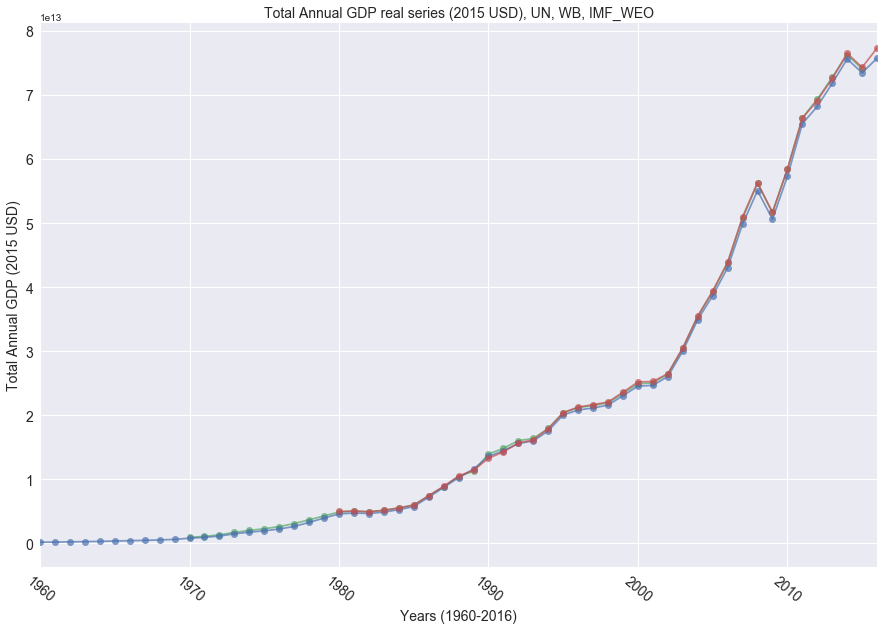

In [108]:
def plot_total(_df, source):
    '''
    Calculates and plots the total annual gdp values based on input dataframe
    
    Parameters
    ----------
    _df: DataFrame
        dataframe of gdp series (country x years), a single source
    _source: str
        string name of the data source

    Return
    -------
    None
    '''
    meta = {
        'un': ('United Nations', '1970-2015', 'go-'),
        'wb': ('World Bank', '1960-2016', 'bo-'),
        'imf_weo': ('Internatioal Financial Statistics - World Economic Outlook', '1980-2016', 'ro-'),

    }
    
    _display_name = meta[source][0]
    _years = meta[source][1]
    _color =meta[source][2]
    
    total_series = _df.sum(axis=0)
    tt = total_series.T.plot(style=_color, 
                   figsize=(15, 10),
                   fontsize=14, grid=True, rot=320, alpha=.7, ms=7)
     
    label_axes(tt, 
           'Years (1960-2016)', 
           'Total Annual GDP (2015 USD)',
            'Total Annual GDP real series (2015 USD), UN, WB, IMF_WEO')
#             'Total Annual GDP real series, {0} Data ({1})'.format(_display_name, _years)) 

    
plot_total(un_real_b2015, 'un')
plot_total(wb_real_b2015, 'wb')
plot_total(weo_real_b2015, 'imf_weo')

# overwriting legends, and no labels (color - source). ignore for now. this is just sanity check (will be using xarray)

In [ ]:
# calculate gdp index and get nominal series (PWT) -> use rgdnpa (but convert base year**)


In [ ]:

# imf calculate real seires (gdi * nominal)
# calculate per capital values
# revisit four major countries for IFS data (individual download)